# MW-M31 Post-Merger Remnant

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Shape" data-toc-modified-id="Shape-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Shape</a></span></li><li><span><a href="#Mass-profiles" data-toc-modified-id="Mass-profiles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Mass profiles</a></span><ul class="toc-item"><li><span><a href="#Hernquist-fits" data-toc-modified-id="Hernquist-fits-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Hernquist fits</a></span></li><li><span><a href="#Sersic-fits" data-toc-modified-id="Sersic-fits-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Sersic fits</a></span></li></ul></li><li><span><a href="#Densities" data-toc-modified-id="Densities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Densities</a></span></li><li><span><a href="#Oriented-views" data-toc-modified-id="Oriented-views-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Oriented views</a></span></li><li><span><a href="#Rotation" data-toc-modified-id="Rotation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Rotation</a></span><ul class="toc-item"><li><span><a href="#Specific-angular-momentum" data-toc-modified-id="Specific-angular-momentum-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Specific angular momentum</a></span></li><li><span><a href="#Halo-angular-momentum" data-toc-modified-id="Halo-angular-momentum-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Halo angular momentum</a></span></li><li><span><a href="#Phase-diagrams" data-toc-modified-id="Phase-diagrams-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Phase diagrams</a></span></li></ul></li><li><span><a href="#Velocity-dispersion" data-toc-modified-id="Velocity-dispersion-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Velocity dispersion</a></span></li><li><span><a href="#Mass-profile" data-toc-modified-id="Mass-profile-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Mass profile</a></span></li></ul></div>

## Setup

In [1]:
# import modules
import numpy as np
import numpy.linalg as la
from scipy.optimize import curve_fit
import pandas as pd
import astropy.units as u

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mpl_scatter_density
from matplotlib import rcParams

# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
im_norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

%matplotlib inline

In [2]:
# my modules
from galaxy.galaxy import Galaxy
from galaxy.centerofmass import CenterOfMass
from galaxy.massprofile import MassProfile
from galaxy.plots import Plots
from galaxy.timecourse import TimeCourse

In [3]:
from galaxy.remnant import Remnant

In [4]:
tc = TimeCourse()

In [5]:
# Just luminous particles: ptype defaults to (2,3)
remnant = Remnant(usesql=True)

In [6]:
remnant.data, remnant.data.shape

(array([('M31', 2, 2.000e-05, 196.939, 24.1967, 139.881, 260.831  ,  -85.0969, -26.0921),
        ('M31', 2, 2.000e-05, 189.087, 20.2326, 146.165,  18.4025 ,   23.0247,  32.5107),
        ('M31', 2, 2.000e-05, 206.619, 19.0085, 122.444, -62.8166 , -162.355 , 181.913 ),
        ...,
        ('MW ', 3, 2.001e-05, 171.059, 13.8007, 128.251,  42.7172 ,  -34.8959,  64.3355),
        ('MW ', 3, 2.001e-05, 188.957, 23.4792, 147.111, 257.351  ,  -53.4361, -95.3574),
        ('MW ', 3, 2.001e-05, 189.534, 21.7683, 148.253,  -2.96004,   82.9176,  26.7174)],
       dtype=[('galname', '<U3'), ('type', 'u1'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4')]),
 (1120000,))

In [7]:
def get_counts(remnant):
    df = pd.DataFrame()
    df['gal'] = remnant.data['galname']
    df['type'] = remnant.data['type']

    # create some better column names
    types = {1: 'Halo', 2: 'Disk', 3: 'Bulge'}
    df['typename'] = df['type'].map(types)

    # get pandas to do most of the work
    df_piv = pd.pivot_table(df, values='type',
                            index='gal', columns='typename',
                            aggfunc='count', fill_value=0, margins=True)
    return df_piv

In [8]:
counts = get_counts(remnant) / 1000
counts

typename,Bulge,Disk,All
gal,,,
M31,95.0,600.0,695.0
MW,50.0,375.0,425.0
All,145.0,975.0,1120.0


In [9]:
print(counts.to_latex())

\begin{tabular}{lrrr}
\toprule
typename &  Bulge &   Disk &     All \\
gal &        &        &         \\
\midrule
M31 &   95.0 &  600.0 &   695.0 \\
MW  &   50.0 &  375.0 &   425.0 \\
All &  145.0 &  975.0 &  1120.0 \\
\bottomrule
\end{tabular}



## Shape

Get remnant-centered coordinates: just translation, no rotation at this stage

In [10]:
com = CenterOfMass(remnant, ptype=None)

In [11]:
xyz, vxyz = com.center_com()

In [12]:
xyz.shape

(3, 1120000)

Define some methods to calculate principal axes of the (presumed) ellipsoid:

In [13]:
def get_where(gal, ptype):
    if gal == 'MW':
        gal = 'MW ' # annoying!
    return np.where((remnant.data['galname']==gal) & (remnant.data['type']==ptype))

def sub_ellipsoid_axes(subset):
    x,y,z = (xyz.T[subset]).T
    m = remnant.data[subset]['m']

    return remnant.ellipsoid_axes(m, x, y, z)

Subset the data by origin, galaxy/particle type:

In [14]:
MWh = get_where('MW', 1)
MWd = get_where('MW', 2)
MWb = get_where('MW', 3)
M31h = get_where('M31', 1)
M31d = get_where('M31', 2)
M31b = get_where('M31', 3)

In [15]:
x,y,z = xyz
m = remnant.data['m']
abc = {}
axes = {}

abc['total'], axes['total'] = remnant.ellipsoid_axes(m, x, y, z)

abc['MWd'], axes['MWd'] = sub_ellipsoid_axes(MWd)
abc['MWb'], axes['MWb'] = sub_ellipsoid_axes(MWb)
abc['M31d'], axes['M31d'] = sub_ellipsoid_axes(M31d)
abc['M31b'], axes['M31b'] = sub_ellipsoid_axes(M31b)
abc, axes

({'total': (1.0, 0.9355179066920681, 0.7736424083691683),
  'MWd': (1.0, 0.9005280163753613, 0.5280240700883598),
  'MWb': (1.0, 0.8889104042615225, 0.7611752037889253),
  'M31d': (1.0, 0.877483894748297, 0.7110574363688984),
  'M31b': (1.0, 0.7783254987701622, 0.7096328212618908)},
 {'total': (array([ 0.06962003, -0.9963229 , -0.04993812], dtype=float32),
   array([-0.42273688, -0.07480813,  0.9031596 ], dtype=float32),
   array([-0.90357435, -0.04176731, -0.42639056], dtype=float32)),
  'MWd': (array([-0.44006893,  0.6355693 ,  0.63434297], dtype=float32),
   array([-0.17750293, -0.75405484,  0.6323718 ], dtype=float32),
   array([-0.88024545, -0.16568942, -0.4446515 ], dtype=float32)),
  'MWb': (array([-0.29315642,  0.9529263 , -0.07740033], dtype=float32),
   array([-0.41765854, -0.05482182,  0.9069487 ], dtype=float32),
   array([-0.860012  , -0.29820472, -0.41406918], dtype=float32)),
  'M31d': (array([-0.22152026,  0.05470886,  0.9736199 ], dtype=float32),
   array([-0.6402247, 

Use pandas to organize and output the results:

In [16]:
df = pd.DataFrame()

df['set'] = np.array([k for k, _ in abc.items()])
df['a'] = np.array([np.round(v[0], 2) for _, v in abc.items()])
df['b'] = np.array([np.round(v[1], 2) for _, v in abc.items()])
df['c'] = np.array([np.round(v[2], 2) for _, v in abc.items()])
print(df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
   set &    a &     b &     c \\
\midrule
 total &  1.0 &  0.94 &  0.77 \\
   MWd &  1.0 &  0.90 &  0.53 \\
   MWb &  1.0 &  0.89 &  0.76 \\
  M31d &  1.0 &  0.88 &  0.71 \\
  M31b &  1.0 &  0.78 &  0.71 \\
\bottomrule
\end{tabular}



What is the relative orientation of component ellipsoids?

In [17]:
def tilt_angle(group1, group2):
    # these should already be unit vectors, but normalise for safety
    vec1 = axes[group1][0]/la.norm(axes[group1][0])
    vec2 = axes[group2][0]/la.norm(axes[group2][0])
    dot = np.dot(vec1, vec2)
    return np.round(np.arccos(np.abs(dot)) * 180 / np.pi, 1)        

In [18]:
groups = [k for k,_ in abc.items()]
tilts = pd.DataFrame([[tilt_angle(g1, g2) for g1 in groups] for g2 in groups], columns=groups)
print(groups)
tilts

['total', 'MWd', 'MWb', 'M31d', 'M31b']


,total,MWd,MWb,M31d,M31b
0,0.0,45.9,15.0,83.2,19.4
1,45.9,0.0,46.7,41.4,60.6
2,15.0,46.7,0.0,87.6,32.4
3,83.2,41.4,87.6,0.0,89.0
4,19.4,60.6,32.4,89.0,0.0


In [19]:
print(tilts.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  total &   MWd &   MWb &  M31d &  M31b \\
\midrule
0 &    0.0 &  45.9 &  15.0 &  83.2 &  19.4 \\
1 &   45.9 &   0.0 &  46.7 &  41.4 &  60.6 \\
2 &   15.0 &  46.7 &   0.0 &  87.6 &  32.4 \\
3 &   83.2 &  41.4 &  87.6 &   0.0 &  89.0 \\
4 &   19.4 &  60.6 &  32.4 &  89.0 &   0.0 \\
\bottomrule
\end{tabular}



## Mass profiles

Work here with all particles, both baryonic and DM:

In [20]:
snap = 801
full_remnant = Remnant(snap=snap, usesql=True, ptype=(1,2,3))
mp = MassProfile(full_remnant)
t = tc.snap2time(snap)

In [21]:
counts = get_counts(full_remnant) / 1000
counts

typename,Bulge,Disk,Halo,All
gal,,,,
M31,95.0,600.0,250.0,945.0
MW,50.0,375.0,250.0,675.0
All,145.0,975.0,500.0,1620.0


Fit the Hernquist profile for DM particles of all origins:

In [22]:
fitted_a, err = mp.fit_hernquist_a(get_details=True)
fitted_a, err

(<Quantity 84.5 kpc>, <Quantity 0.5 kpc>)

Define some radii, then plot:

In [23]:
radii = np.linspace(0.1, 100) * u.kpc

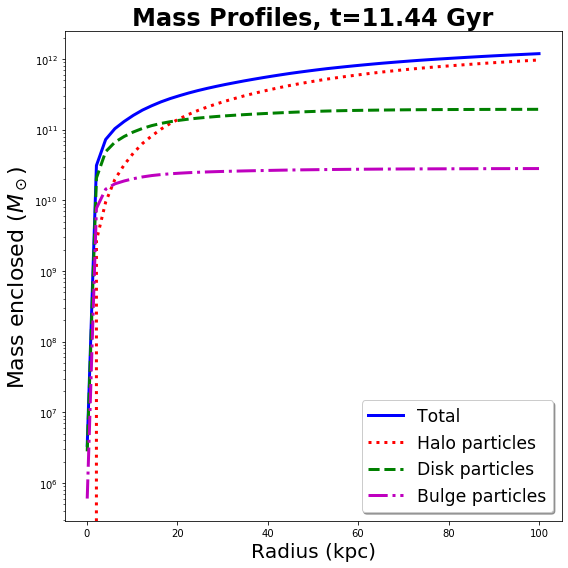

In [24]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()

# add the curves
ax.semilogy(radii, mp.mass_enclosed_total(radii), 'b-', lw=3, 
            label='Total')
ax.semilogy(radii, mp.mass_enclosed(radii, 1), 'r:', lw=3, 
            label='Halo particles')
ax.semilogy(radii, mp.mass_enclosed(radii, 2), 'g--', lw=3, 
            label='Disk particles')
ax.semilogy(radii, mp.mass_enclosed(radii, 3), 'm-.', lw=3, 
            label='Bulge particles')

#adjust tick label font size
label_size = 16
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels and subplot title
ax.set_xlabel('Radius (kpc)', fontsize=20)
ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
ax.legend(loc='lower right',fontsize='xx-large', shadow=True)

#set axis limits
# ax.set_ylim(ylim[0], ylim[1])

# Overall title
ax.set_title(f'Mass Profiles, t={t:.2f} Gyr', y=1.0, 
            fontsize=24, weight='bold')
plt.tight_layout()
plt.savefig('remnant_mp_types.pdf', rasterized=True, dpi=350);

In [25]:
def sub_coords(m, xyz, subset):
    xyz = (xyz.T[subset]).T
    m = m[subset]

    return m, xyz

In [26]:
m = full_remnant.data['m']

com = CenterOfMass(full_remnant, ptype=None)
xyz, vxyz = com.center_com()
xyz.shape

(3, 1620000)

In [27]:
def get_full_where(gal, ptype):
    if gal == 'MW':
        gal = 'MW ' # annoying!
    return np.where((full_remnant.data['galname']==gal) & (full_remnant.data['type']==ptype))

Subset the data by origin, galaxy/particle type:

In [28]:
MWh = get_full_where('MW', 1)
MWd = get_full_where('MW', 2)
MWb = get_full_where('MW', 3)
M31h = get_full_where('M31', 1)
M31d = get_full_where('M31', 2)
M31b = get_full_where('M31', 3)

m_MWd, xyz_MWd = sub_coords(m, xyz, MWd)
m_MWh, xyz_MWh = sub_coords(m, xyz, MWh)
m_MWb, xyz_MWb = sub_coords(m, xyz, MWb)
m_M31d, xyz_M31d = sub_coords(m, xyz, M31d)
m_M31h, xyz_M31h = sub_coords(m, xyz, M31h)
m_M31b, xyz_M31b = sub_coords(m, xyz, M31b)

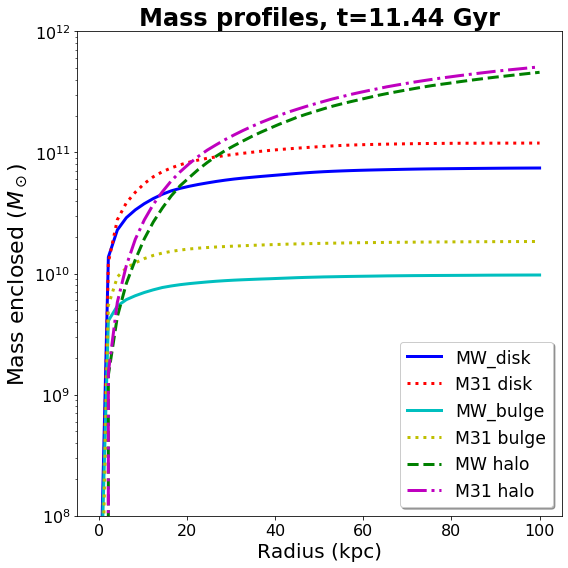

In [29]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()

# data
radii = np.linspace(0.1, 100) * u.kpc

# add the curves
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_MWd, xyz_MWd), 'b-',
             lw=3, label='MW_disk')
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_M31d, xyz_M31d), 'r:',
             lw=3, label='M31 disk')
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_MWb, xyz_MWb), 'c-', 
             lw=3, label='MW_bulge')
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_M31b, xyz_M31b), 'y:',
             lw=3, label='M31 bulge')
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_MWh, xyz_MWh), 'g--',
             lw=3, label='MW halo')
ax.semilogy(radii, full_remnant.sub_mass_enclosed(radii, m_M31h, xyz_M31h), 'm-.',
             lw=3, label='M31 halo')

#adjust tick label font size
label_size = 16
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels and subplot title
ax.set_xlabel('Radius (kpc)', fontsize=20)
ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
ax.legend(loc='lower right',fontsize='xx-large', shadow=True)

#set axis limits
ax.set_ylim(1e8, 1e12)

# Overall title
ax.set_title(f'Mass profiles, t={t:.2f} Gyr', y=1.0, 
            fontsize=24, weight='bold')
plt.tight_layout()
plt.savefig('remnant_mp_origins.pdf', rasterized=True, dpi=350);

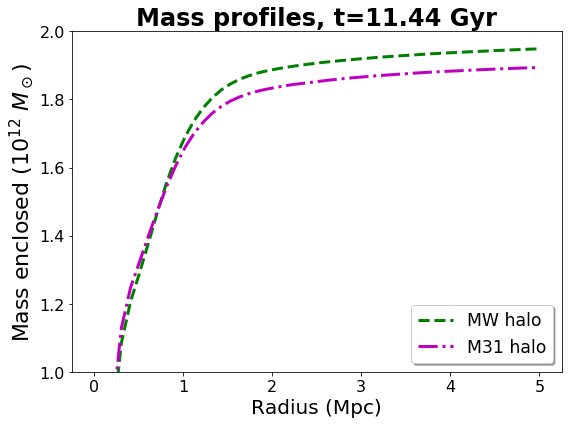

In [31]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()

# data
radii5M = np.linspace(5, 5000) * u.kpc

# add the curves
ax.plot(radii5M/1e3, full_remnant.sub_mass_enclosed(radii5M, m_MWh, xyz_MWh)/1e12, 
             'g--', lw=3, label='MW halo')
ax.plot(radii5M/1e3, full_remnant.sub_mass_enclosed(radii5M, m_M31h, xyz_M31h)/1e12,
              'm-.', lw=3, label='M31 halo')

#adjust tick label font size
label_size = 16
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels and subplot title
ax.set_xlabel('Radius (Mpc)', fontsize=20)
ax.set_ylabel(r'Mass enclosed ($10^{12}\ M_\odot$)', fontsize=22)
ax.legend(loc='lower right',fontsize='xx-large', shadow=True)

#set axis limits
ax.set_ylim(1, 2)

# Overall title
ax.set_title(f'Mass profiles, t={t:.2f} Gyr', y=1.0, 
            fontsize=24, weight='bold')
plt.tight_layout()
plt.savefig('remnant_mp_halo.pdf', rasterized=True, dpi=350);

### Hernquist fits

In [32]:
hnames = ['MW halo','M31 halo']
hprofiles = [(m_MWh, xyz_MWh), (m_M31h, xyz_M31h)]

In [33]:
print("Hernquist fits for remnant subsets\n")
for i, (m, xyz) in enumerate(hprofiles):
    n, err = full_remnant.fit_hernquist_a(m, xyz)
    print(f"{hnames[i]:>4} n = {n:5.2f} +/- {err:.2f}")

Hernquist fits for remnant subsets

MW halo n = 95.19 kpc +/- 1.36 kpc
M31 halo n = 82.30 kpc +/- 0.89 kpc


### Sersic fits

In [34]:
def sersic_data(radii, m, xyz):
    sub_Re, sub_total, subI = full_remnant.Re(radii, m, xyz)
    n, err = full_remnant.fit_sersic_n(radii, sub_Re, sub_total, subI)
    Sersic = full_remnant.sersic(radii.value, sub_Re.value, n, sub_total)
    return sub_Re, sub_total, subI, n, err, Sersic

In [35]:
lnames = ['MW disk','M31 disk', 'MW bulge','M31 bulge']
lprofiles = [(m_MWd, xyz_MWd), (m_M31d, xyz_M31d),
           (m_MWb, xyz_MWb), (m_M31b, xyz_M31b)]

In [36]:
radii60 = np.linspace(2, 60) * u.kpc

for i, (m, xyz) in enumerate(lprofiles):
    sub_Re, sub_total, subI, n, err, Sersic = sersic_data(radii60, m, xyz)
    print(f"{lnames[i]:>4} n = {n:4.2f} +/- {err:.3f}")

MW disk n = 5.35 +/- 0.000
M31 disk n = 5.43 +/- 0.001
MW bulge n = 5.46 +/- 0.000
M31 bulge n = 5.42 +/- 0.000


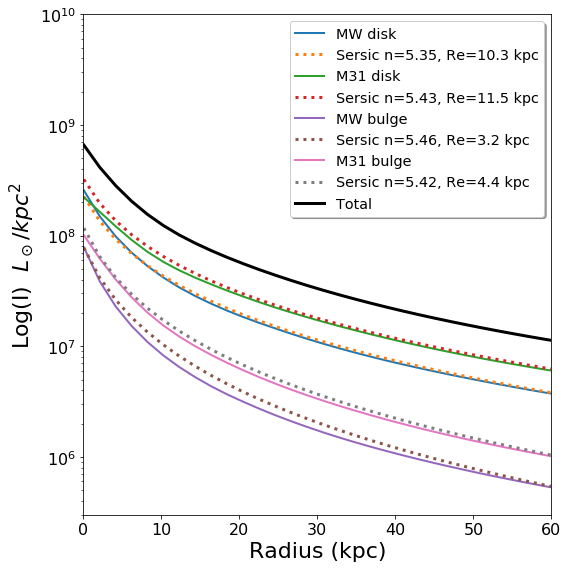

In [37]:
fig = plt.figure(figsize=(8,8))
# subplots = (121, 122)

ax0 = plt.subplot()

subIs = []

# plot the luminosity density as a proxy for surface brightness
for i, (m, xyz) in enumerate(lprofiles):
    sub_Re, sub_total, subI, n, err, Sersic = sersic_data(radii60, m, xyz)
    subIs.append(subI)
    ax0.semilogy(radii, subI, lw=2, label=f'{lnames[i]}')
    ax0.semilogy(radii, Sersic, lw=3, ls=':',
                     label=f'Sersic n={n:.2f}, Re={sub_Re:.1f}')
total_I = subIs[0]
for I in subIs[1:]:
    total_I += I
ax0.semilogy(radii, total_I, 'k-', lw=3, label='Total')

# Add axis labels
ax0.set_xlabel('Radius (kpc)', fontsize=22)
ax0.set_ylabel('Log(I)  $L_\odot/kpc^2$', fontsize=22)

ax0.set_xlim(0,60)
ax0.set_ylim(3e5, 1e10)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax0.legend(fontsize='x-large', shadow=True)
plt.tight_layout()
plt.savefig('remnant_sersic_origins.pdf', rasterized=True, dpi=350);

## Densities

In [38]:
def density_profile(radii, m, xyz):
    r = la.norm(xyz, axis=0)
    enc_mask = r[:, np.newaxis] < np.asarray(radii).flatten()
    m_enc = np.sum(m[:, np.newaxis] * enc_mask, axis=0)
    m_annuli = np.diff(m_enc) * 1e10 * u.M_sun
    rho = 3/(4*np.pi) * m_annuli / (radii[1:]**3 - radii[:-1]**3)
    r_annuli = np.sqrt(radii[1:] * radii[:-1])
    return r_annuli, rho

In [39]:
density_profile(radii, m, xyz)

(<Quantity [ 0.46246897,  2.98912091,  5.09598089,  7.16354729,  9.21829754,
            11.26724547, 13.31307037, 15.35702041, 17.39975633, 19.44166083,
            21.48297099, 23.52384153, 25.56437774, 27.60465377, 29.64472332,
            31.6846263 , 33.72439291, 35.7640465 , 37.80360536, 39.84308403,
            41.88249424, 43.92184551, 45.9611457 , 48.00040131, 50.03961779,
            52.07879974, 54.11795107, 56.15707511, 58.19617472, 60.23525239,
            62.27431028, 64.31335026, 66.35237399, 68.39138292, 70.43037834,
            72.46936138, 74.50833306, 76.54729429, 78.58624589, 80.62518858,
            82.66412302, 84.70304981, 86.74196949, 88.78088255, 90.81978943,
            92.85869055, 94.89758626, 96.93647692, 98.97536284] kpc>,
 <Quantity [1.33266798e+08, 1.48100950e+07, 2.54474626e+06, 8.22163757e+05,
            4.61167667e+05, 2.51620252e+05, 1.38989588e+05, 8.05677123e+04,
            5.01964491e+04, 3.24537482e+04, 2.13281376e+04, 1.37385910e+04,
         

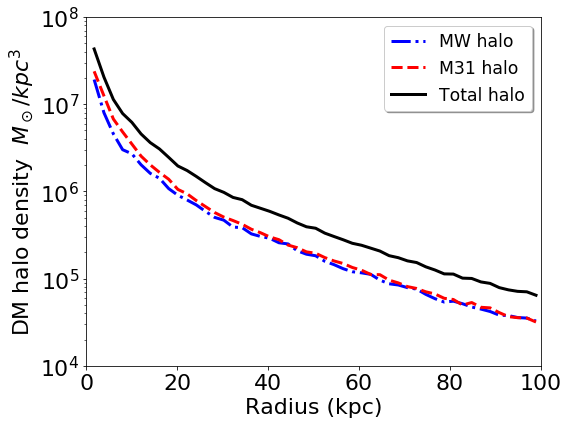

In [40]:
fig = plt.figure(figsize=(8,6))
ax0 = plt.subplot()

radii100 = np.linspace(1, 100) * u.kpc

styles = ['b-.', 'r--', 'g:', 'y.-']

# plot the mass density 
rhos = []
for i, (m, xyz) in enumerate(hprofiles):
    r_annuli, rho = density_profile(radii100, m, xyz)
    rhos.append(rho)
    ax0.semilogy(r_annuli, rho, styles[i], lw=3, label=f'{hnames[i]}')
rho_total = rhos[0] + rhos[1]
ax0.semilogy(r_annuli, rho_total, 'k-', lw=3, label='Total halo')
#     ax0.semilogy(radii, Sersic, lw=3, ls=':',
#                      label=f'Sersic n={n:.2f}, Re={sub_Re:.1f}')

# Add axis labels
ax0.set_xlabel('Radius (kpc)', fontsize=22)
ax0.set_ylabel('DM halo density  $M_\odot/kpc^3$', fontsize=22)

ax0.set_xlim(0,100)
ax0.set_ylim(1e4, 1e8)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax0.legend(fontsize='xx-large', shadow=True)
plt.tight_layout()
plt.savefig('remnant_DM_rho.pdf', rasterized=True, dpi=350);

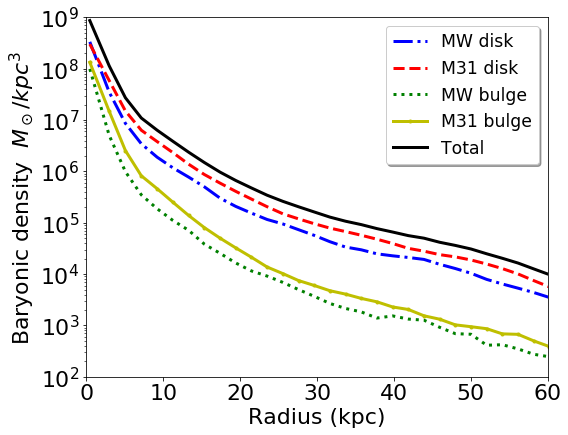

In [41]:
fig = plt.figure(figsize=(8,6))
ax0 = plt.subplot()

styles = ['b-.', 'r--', 'g:', 'y.-']

rhos = []

# plot the mass density 
for i, (m, xyz) in enumerate(lprofiles):
    r_annuli, rho = density_profile(radii, m, xyz)
    rhos.append(rho)
    ax0.semilogy(r_annuli, rho, styles[i], lw=3, label=f'{lnames[i]}')

total_rho = rhos[0]
for r in rhos[1:]:
    total_rho += r
ax0.semilogy(r_annuli, total_rho, 'k-', lw=3, label='Total')

# Add axis labels
ax0.set_xlabel('Radius (kpc)', fontsize=22)
ax0.set_ylabel('Baryonic density  $M_\odot/kpc^3$', fontsize=22)

ax0.set_xlim(0,60)
ax0.set_ylim(1e2, 1e9)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax0.legend(fontsize='xx-large', shadow=True)
plt.tight_layout()
plt.savefig('remnant_lum_rho.pdf', rasterized=True, dpi=350);

## Oriented views

In [42]:
L, pos, v = com.angular_momentum()
L

array([ 2.4601861e+09, -3.1331875e+08, -2.9613629e+09], dtype=float32)

In [43]:
xyz_rot, vxyz_rot = com.rotate_frame()

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


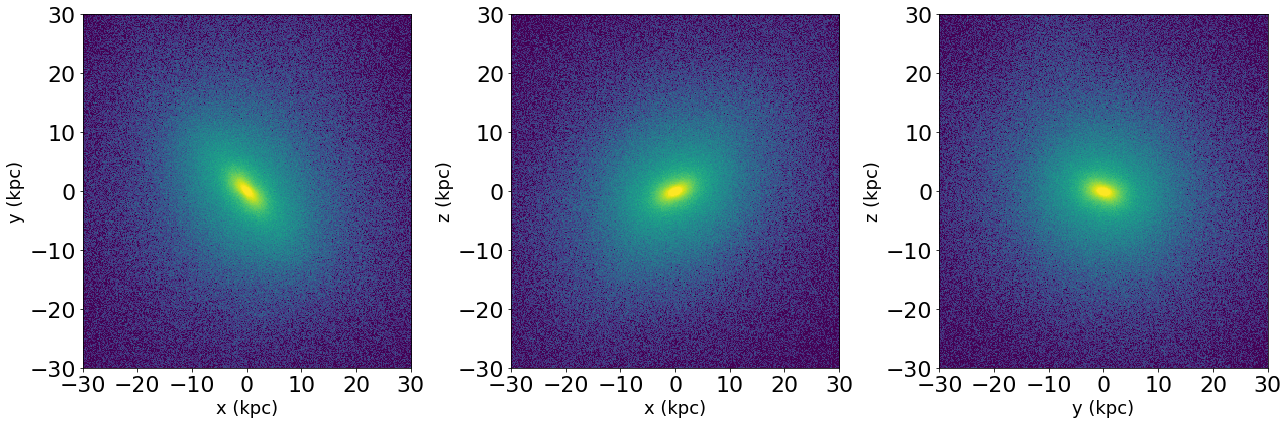

In [44]:
fig = plt.figure(figsize=(18,6))

lim = 30 # axes +/- lim
fontsize = 18 # for labels

# left plot x-y
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(xyz_rot[0], xyz_rot[1], norm=im_norm)

ax0.set_xlim(-lim, lim)
ax0.set_ylim(-lim, lim)

ax0.set_xlabel('x (kpc)', fontsize=fontsize)
ax0.set_ylabel('y (kpc)', fontsize=fontsize)

# mid plot x-z
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(xyz_rot[0], xyz_rot[2], norm=im_norm)

ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

ax1.set_xlabel('x (kpc)', fontsize=fontsize)
ax1.set_ylabel('z (kpc)', fontsize=fontsize)

# right plot y-z
ax2 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax2.scatter_density(xyz_rot[1], xyz_rot[2], norm=im_norm)

ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

ax2.set_xlabel('y (kpc)', fontsize=fontsize)
ax2.set_ylabel('z (kpc)', fontsize=fontsize);

#adjust tick label font size
label_size = 16
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.tight_layout()
plt.savefig('remnant_shape.pdf', rasterized=True, dpi=350);

## Rotation

Refresh data:

In [45]:
m = full_remnant.data['m']
xyz = full_remnant.xyz() * u.kpc
vxyz = full_remnant.vxyz() * u.km/u.s

### Specific angular momentum 

For total and various subsets:

In [46]:
spec_angmoms = {}

In [47]:
L = np.sum(np.cross(xyz, m*vxyz, axis=0), axis=1)
h = L / np.sum(m)
spec_angmoms['total'] = h.to(u.kpc**2/u.Myr)
spec_angmoms['total']

<Quantity [ 8.210495  ,  0.35235673, -9.772663  ] kpc2 / Myr>

In [48]:
def sub_spec_angmom(m, xyz, vxyz, subset):
    xyz = (xyz.T[subset]).T
    vxyz = (vxyz.T[subset]).T
    m = m[subset]
    L = np.sum(np.cross(xyz, m*vxyz, axis=0), axis=1)
    h = L / np.sum(m)

    return h.to(u.kpc**2/u.Myr)

In [49]:
spec_angmoms['MWd'] = sub_spec_angmom(m, xyz, vxyz, MWd)
spec_angmoms['M31d'] = sub_spec_angmom(m, xyz, vxyz, M31d)
spec_angmoms['MWb'] = sub_spec_angmom(m, xyz, vxyz, MWb)
spec_angmoms['M31b'] = sub_spec_angmom(m, xyz, vxyz, M31b)
spec_angmoms['MWh'] = sub_spec_angmom(m, xyz, vxyz, MWh)
spec_angmoms['M31h'] = sub_spec_angmom(m, xyz, vxyz, M31h)

spec_angmoms

{'total': <Quantity [ 8.210495  ,  0.35235673, -9.772663  ] kpc2 / Myr>,
 'MWd': <Quantity [ 4.1791186, -0.8213118, -4.817594 ] kpc2 / Myr>,
 'M31d': <Quantity [ 3.3506982, -1.3390776, -5.138587 ] kpc2 / Myr>,
 'MWb': <Quantity [ 4.2153964 , -0.31096596, -5.321216  ] kpc2 / Myr>,
 'M31b': <Quantity [ 3.7819676, -0.7636344, -4.880085 ] kpc2 / Myr>,
 'MWh': <Quantity [ 11.225205 ,   1.5766778, -12.514615 ] kpc2 / Myr>,
 'M31h': <Quantity [ 5.6369724, -0.7404647, -7.5083976] kpc2 / Myr>}

Make a table with unit vectors and magnitude:

In [50]:
rot_df = pd.DataFrame()

rot_df['set'] = np.array([k for k, _ in spec_angmoms.items()])
rot_df['h_x'] = np.array([np.round(v[0].value / la.norm(v.value), 2) for _, v in spec_angmoms.items()])
rot_df['h_y'] = np.array([np.round(v[1].value / la.norm(v.value), 2) for _, v in spec_angmoms.items()])
rot_df['h_z'] = np.array([np.round(v[2].value / la.norm(v.value), 2) for _, v in spec_angmoms.items()])
rot_df['h_mag'] = np.array([np.round(la.norm(v, axis=0).value, 2) for _, v in spec_angmoms.items()])

print(rot_df.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
   set &   h\_x &   h\_y &   h\_z &      h\_mag \\
\midrule
 total &  0.64 &  0.03 & -0.77 &  12.770000 \\
   MWd &  0.65 & -0.13 & -0.75 &   6.430000 \\
  M31d &  0.53 & -0.21 & -0.82 &   6.280000 \\
   MWb &  0.62 & -0.05 & -0.78 &   6.800000 \\
  M31b &  0.61 & -0.12 & -0.78 &   6.220000 \\
   MWh &  0.66 &  0.09 & -0.74 &  16.889999 \\
  M31h &  0.60 & -0.08 & -0.80 &   9.420000 \\
\bottomrule
\end{tabular}



In [51]:
rot_df

,set,h_x,h_y,h_z,h_mag
0,total,0.64,0.03,-0.77,12.770000
1,MWd,0.65,-0.13,-0.75,6.430000
2,M31d,0.53,-0.21,-0.82,6.280000
3,MWb,0.62,-0.05,-0.78,6.800000
4,M31b,0.61,-0.12,-0.78,6.220000
5,MWh,0.66,0.09,-0.74,16.889999
6,M31h,0.60,-0.08,-0.80,9.420000


Relative alignment of various angular momentum vectors:

In [52]:
def rot_tilt_angle(group1, group2):
    vec1 = spec_angmoms[group1]/la.norm(spec_angmoms[group1])
    vec2 = spec_angmoms[group2]/la.norm(spec_angmoms[group2])
    dot = np.dot(vec1, vec2)
    return np.round(np.arccos(np.abs(dot)).to(u.degree).value, 1)        

In [53]:
groups = [k for k,_ in spec_angmoms.items()]
rot_tilts = pd.DataFrame([[rot_tilt_angle(g1, g2) for g1 in groups] for g2 in groups], columns=groups)
print(groups)
rot_tilts

['total', 'MWd', 'M31d', 'MWb', 'M31b', 'MWh', 'M31h']


/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in arccos
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


,total,MWd,M31d,MWb,M31b,MWh,M31h
0,0.0,9.0,15.5,4.5,8.9,4.2,6.9
1,9.0,0.0,9.2,5.4,3.2,12.7,4.9
2,15.5,9.2,0.0,11.0,7.0,19.7,8.7
3,4.5,5.4,11.0,NaN,4.5,8.7,2.4
4,8.9,3.2,7.0,4.5,NaN,13.1,2.7
5,4.2,12.7,19.7,8.7,13.1,NaN,11.1
6,6.9,4.9,8.7,2.4,2.7,11.1,NaN


In [54]:
print(rot_tilts.to_latex(index=True))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  total &   MWd &  M31d &   MWb &  M31b &   MWh &  M31h \\
\midrule
0 &    0.0 &   9.0 &  15.5 &   4.5 &   8.9 &   4.2 &   6.9 \\
1 &    9.0 &   0.0 &   9.2 &   5.4 &   3.2 &  12.7 &   4.9 \\
2 &   15.5 &   9.2 &   0.0 &  11.0 &   7.0 &  19.7 &   8.7 \\
3 &    4.5 &   5.4 &  11.0 &   NaN &   4.5 &   8.7 &   2.4 \\
4 &    8.9 &   3.2 &   7.0 &   4.5 &   NaN &  13.1 &   2.7 \\
5 &    4.2 &  12.7 &  19.7 &   8.7 &  13.1 &   NaN &  11.1 \\
6 &    6.9 &   4.9 &   8.7 &   2.4 &   2.7 &  11.1 &   NaN \\
\bottomrule
\end{tabular}



### Halo angular momentum

In [55]:
remn_halo = np.where(full_remnant.data['type']==1)

In [56]:
angmom_halo = sub_spec_angmom(m, xyz, vxyz, remn_halo)
angmom_halo_mag = la.norm(angmom_halo)
angmom_halo_unit = (angmom_halo/angmom_halo_mag).value
angmom_halo_unit, angmom_halo_mag

(array([ 0.6442282 ,  0.03302421, -0.76412   ], dtype=float32),
 <Quantity 13.14736 kpc2 / Myr>)

In [77]:
def halo_angmom(m, xyz, vxyz):
    L = np.sum(np.cross(xyz, m*vxyz, axis=0), axis=1)
    h = L / np.sum(m)

    return h.to(u.kpc**2/u.Myr)

In [86]:
def galaxy_halo_angmom(gal, snap):
    g = Galaxy(gal, snap=snap, ptype=1, usesql=True)
    com_xyz, com_vxyz = tc.get_one_com(gal, snap)
    xyz = (g.xyz() - com_xyz[:, np.newaxis]) * u.kpc
    vxyz = (g.vxyz() - com_vxyz[:, np.newaxis]) * u.km/u.s
    m = g.data['m']
    h = halo_angmom(m, xyz, vxyz)
    halo_mag = la.norm(h)
    halo_unit = (h/halo_mag).value
    return halo_unit, halo_mag

In [87]:
galaxy_halo_angmom('MW',0)

(array([-0.50985  ,  0.7989457, -0.3189649], dtype=float32),
 <Quantity 0.09441618 kpc2 / Myr>)

In [88]:
galaxy_halo_angmom('MW',335)

(array([ 0.6942548 ,  0.15382974, -0.7030979 ], dtype=float32),
 <Quantity 9.752092 kpc2 / Myr>)

In [89]:
galaxy_halo_angmom('M31',0)

(array([-0.1899469, -0.5109069, -0.8383879], dtype=float32),
 <Quantity 0.06030887 kpc2 / Myr>)

In [92]:
(hx, hy, hz), h_mag = galaxy_halo_angmom('M31',335)
hx, hy, hz, h_mag

(0.6676963, 0.16740806, -0.7253662, <Quantity 7.1438656 kpc2 / Myr>)

In [ ]:
with open('./halo_h.txt', 'w') as f:
    f.write(f"# {'gal':>5s}{'snap':>8s}{'t':>8s}{'h_x':>8s}{'h_y':>8s}{'h_z':>8s}{'h_magz':>8s}\n")
    
for galname in ('M31','MW'):
    print(galname)
    for snap in np.arange(0, 802):
        t = tc.snap2time(snap)
        (hx, hy, hz), h_mag = galaxy_halo_angmom(galname, snap)
        with open('./halo_h.txt', 'a') as f:
            f.write(f"{galname:>7s}{snap:8d}{t:8.3f}{hx:8.2f}{hy:8.2f}{hz:8.2f}{h_mag.value:8.3f}\n")   

M31


In [94]:
?np.arange

### Phase diagrams

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


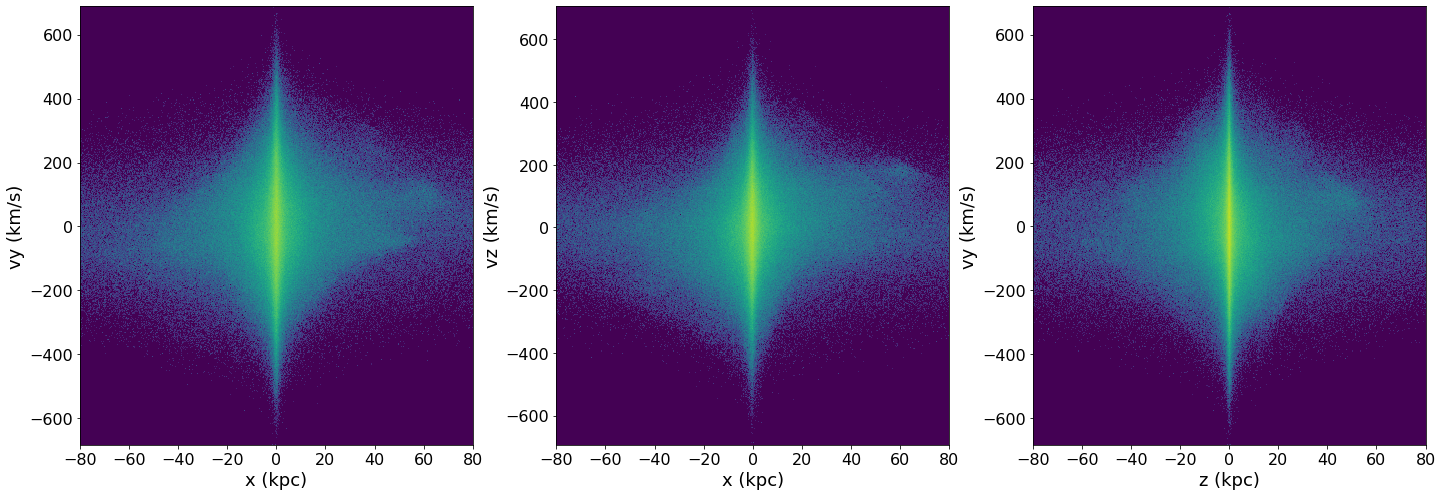

In [59]:
fig = plt.figure(figsize=(20,7))

lim = 80 # axes +/- lim
fontsize = 18 # for labels

# left plot x-vy
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(xyz_rot[0], vxyz_rot[1], norm=im_norm)

ax0.set_xlim(-lim, lim)
# ax0.set_ylim(-lim, lim)

ax0.set_xlabel('x (kpc)', fontsize=fontsize)
ax0.set_ylabel('vy (km/s)', fontsize=fontsize)

# mid plot x-vz
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(xyz_rot[0], vxyz_rot[2], norm=im_norm)

ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('x (kpc)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize);

# right plot z-vy
ax1 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax1.scatter_density(xyz_rot[2], vxyz_rot[1], norm=im_norm)

ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('z (kpc)', fontsize=fontsize)
ax1.set_ylabel('vy (km/s)', fontsize=fontsize);
plt.tight_layout()
plt.savefig('remnant_phase.pdf', rasterized=True, dpi=350);

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


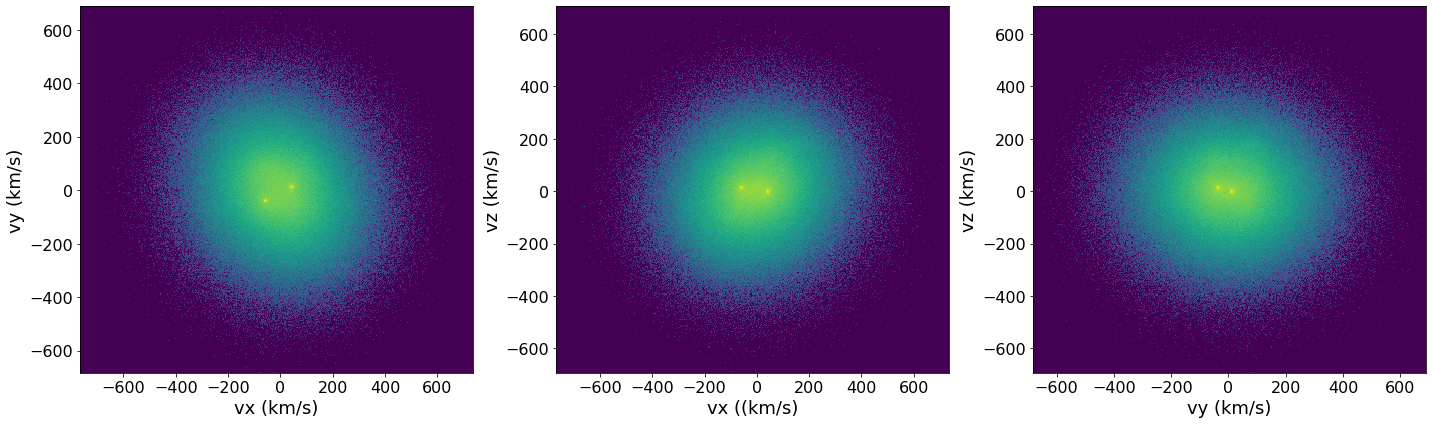

In [60]:
fig = plt.figure(figsize=(20,6))

lim = 80 # axes +/- lim
fontsize = 18 # for labels

# left plot x-vy
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(vxyz_rot[0], vxyz_rot[1], norm=im_norm)

# ax0.set_xlim(-lim, lim)
# ax0.set_ylim(-lim, lim)

ax0.set_xlabel('vx (km/s)', fontsize=fontsize)
ax0.set_ylabel('vy (km/s)', fontsize=fontsize)

# mid plot x-vz
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(vxyz_rot[0], vxyz_rot[2], norm=im_norm)

# ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('vx ((km/s)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize);

# right plot z-vy
ax1 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax1.scatter_density(vxyz_rot[1], vxyz_rot[2], norm=im_norm)

# ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('vy (km/s)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize)
plt.tight_layout();


## Velocity dispersion

## Mass profile